In [1]:
import tensorflow as tf
import numpy as np

TFLITE_MODEL_PATH = "model4.tflite"

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input:", input_details)
print("Output:", output_details)

batch_size = 32
img_height = 256
img_width = 256

val_ds = tf.keras.utils.image_dataset_from_directory(
    'images/',                 
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = [
    "Boldogko_Castle",
    "Buda_Castle",
    "Budapest_Museum_of_Applied_Arts",
    "Budapest_University_of_Technology_and_Economics",
    "Chain_Bridge_(Budapest)",
    "Csesznek_Castle",
    "Debrecen_Reformed_Great_Church",
    "Diosgyor_Castle",
    "Edeleny_L’Huillier_Coburg_Castle",
    "Eger_Castle",
    "Esztergom_Castle",
    "Esztergom_Cathedral",
    "Fertod_Esterhazy_Castle",
    "Fisherman's_Bastion",
    "Füzer_Castle",
    "Fuzerradvany_Karolyi_Castle",
    "Gellért_Baths",
    "Godollo_Grassalkovich_Castle",
    "Great_Synagogue_in_Dohány_Street",
    "Gyula_Castle",
    "Heroes'_Square_(Budapest)",
    "Heviz_Thermal_Lake",
    "Holloko_Castle",
    "Hortobagy_Nine_Hole_Bridge",
    "Hungarian_Parliament_Building",
    "Hungarian_State_Opera_House",
    "Jak_Church",
    "Jurisics_Castle",
    "Keszthely_Festetics_Palace",
    "Kinizsi_Castle",
    "Lillafured_Palace_Hotel",
    "Mako_Hagymatikum",
    "Martonvasar_Brunszvik_Castle",
    "Matthias_Church_(Budapest)",
    "Nadasdladany_Nadasy_Castle",
    "New_York_Palace_(Budapest)",
    "Pecs_Mosque",
    "Rakoczi_Castle",
    "Simontornya_Castle",
    "Siofok_Water_Tower",
    "Sirok_Castle",
    "St._Stephen's_Basilica_(Budapest)",
    "Sumeg_Castle",
    "Szabadkigyos_Wenckheim_Castle",
    "Szeged_Cathedral",
    "Szigliget_Castle",
    "Tata_Castle",
    "Thury_Castle",
    "Tiszadob_Andrassy_Castle",
    "Tura_Schossberger_Castle",
    "Vajdahunyad_Castle_(Budapest)",
    "Visegrad_Castle"
]

AUTOTUNE = tf.data.AUTOTUNE
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Input: [{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([  1, 256, 256,   3]), 'shape_signature': array([ -1, 256, 256,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output: [{'name': 'StatefulPartitionedCall:0', 'index': 495, 'shape': array([ 1, 52]), 'shape_signature': array([-1, 52]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Found 2828 files belonging to 52 classes.
Using 565 files for validation.


In [2]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def tflite_predict_batch(images):
    images = preprocess_input(images.numpy())
    
    preds = []
    for img in images:
        img = np.expand_dims(img, axis=0).astype(np.float32)
        interpreter.set_tensor(input_details[0]['index'], img)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])
        preds.append(output[0])
        
    return np.array(preds)

In [3]:
y_true = []
y_pred = []
y_pred_top5 = []

for images, labels in val_ds:
    logits = tflite_predict_batch(images)
    probs = tf.nn.softmax(logits, axis=1).numpy()
    
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(probs, axis=1))
    y_pred_top5.extend(np.argsort(probs, axis=1)[:, -5:])
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_top5 = np.array(y_pred_top5)

In [4]:
top1_acc = np.mean(y_pred == y_true)

top5_acc = np.mean([
    y_true[i] in y_pred_top5[i]
    for i in range(len(y_true))
])

print(f"Top-1 accuracy (TFLite): {top1_acc:.4f}")
print(f"Top-5 accuracy (TFLite): {top5_acc:.4f}")

Top-1 accuracy (TFLite): 0.6956
Top-5 accuracy (TFLite): 0.9221


In [10]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# classification report dict formában
report_dict = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4,
    output_dict=True
)

print(report_dict)

# DataFrame készítése
df = pd.DataFrame(report_dict).transpose()
df = df.round(4)

# CSV mentés
df.to_csv("classification_report.csv")

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

{'Boldogko_Castle': {'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1-score': 0.6666666666666666, 'support': 15.0}, 'Buda_Castle': {'precision': 0.7894736842105263, 'recall': 0.75, 'f1-score': 0.7692307692307693, 'support': 20.0}, 'Budapest_Museum_of_Applied_Arts': {'precision': 0.8461538461538461, 'recall': 0.9166666666666666, 'f1-score': 0.88, 'support': 12.0}, 'Budapest_University_of_Technology_and_Economics': {'precision': 0.625, 'recall': 0.38461538461538464, 'f1-score': 0.47619047619047616, 'support': 13.0}, 'Chain_Bridge_(Budapest)': {'precision': 0.7272727272727273, 'recall': 0.8888888888888888, 'f1-score': 0.8, 'support': 18.0}, 'Csesznek_Castle': {'precision': 0.8, 'recall': 0.6, 'f1-score': 0.6857142857142857, 'support': 20.0}, 'Debrecen_Reformed_Great_Church': {'precision': 0.6666666666666666, 'recall': 1.0, 'f1-score': 0.8, 'support': 6.0}, 'Diosgyor_Castle': {'precision': 1.0, 'recall': 0.36363636363636365, 'f1-score': 0.5333333333333333, 'support': 11.0

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

print(
    classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        digits=4
    )
)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

                                                 precision    recall  f1-score   support

                                Boldogko_Castle     0.6667    0.6667    0.6667        15
                                    Buda_Castle     0.7895    0.7500    0.7692        20
                Budapest_Museum_of_Applied_Arts     0.8462    0.9167    0.8800        12
Budapest_University_of_Technology_and_Economics     0.6250    0.3846    0.4762        13
                        Chain_Bridge_(Budapest)     0.7273    0.8889    0.8000        18
                                Csesznek_Castle     0.8000    0.6000    0.6857        20
                 Debrecen_Reformed_Great_Church     0.6667    1.0000    0.8000         6
                                Diosgyor_Castle     1.0000    0.3636    0.5333        11
               Edeleny_L’Huillier_Coburg_Castle     0.6667    0.4000    0.5000         5
                                    Eger_Castle     0.6667    0.5455    0.6000        11
                    

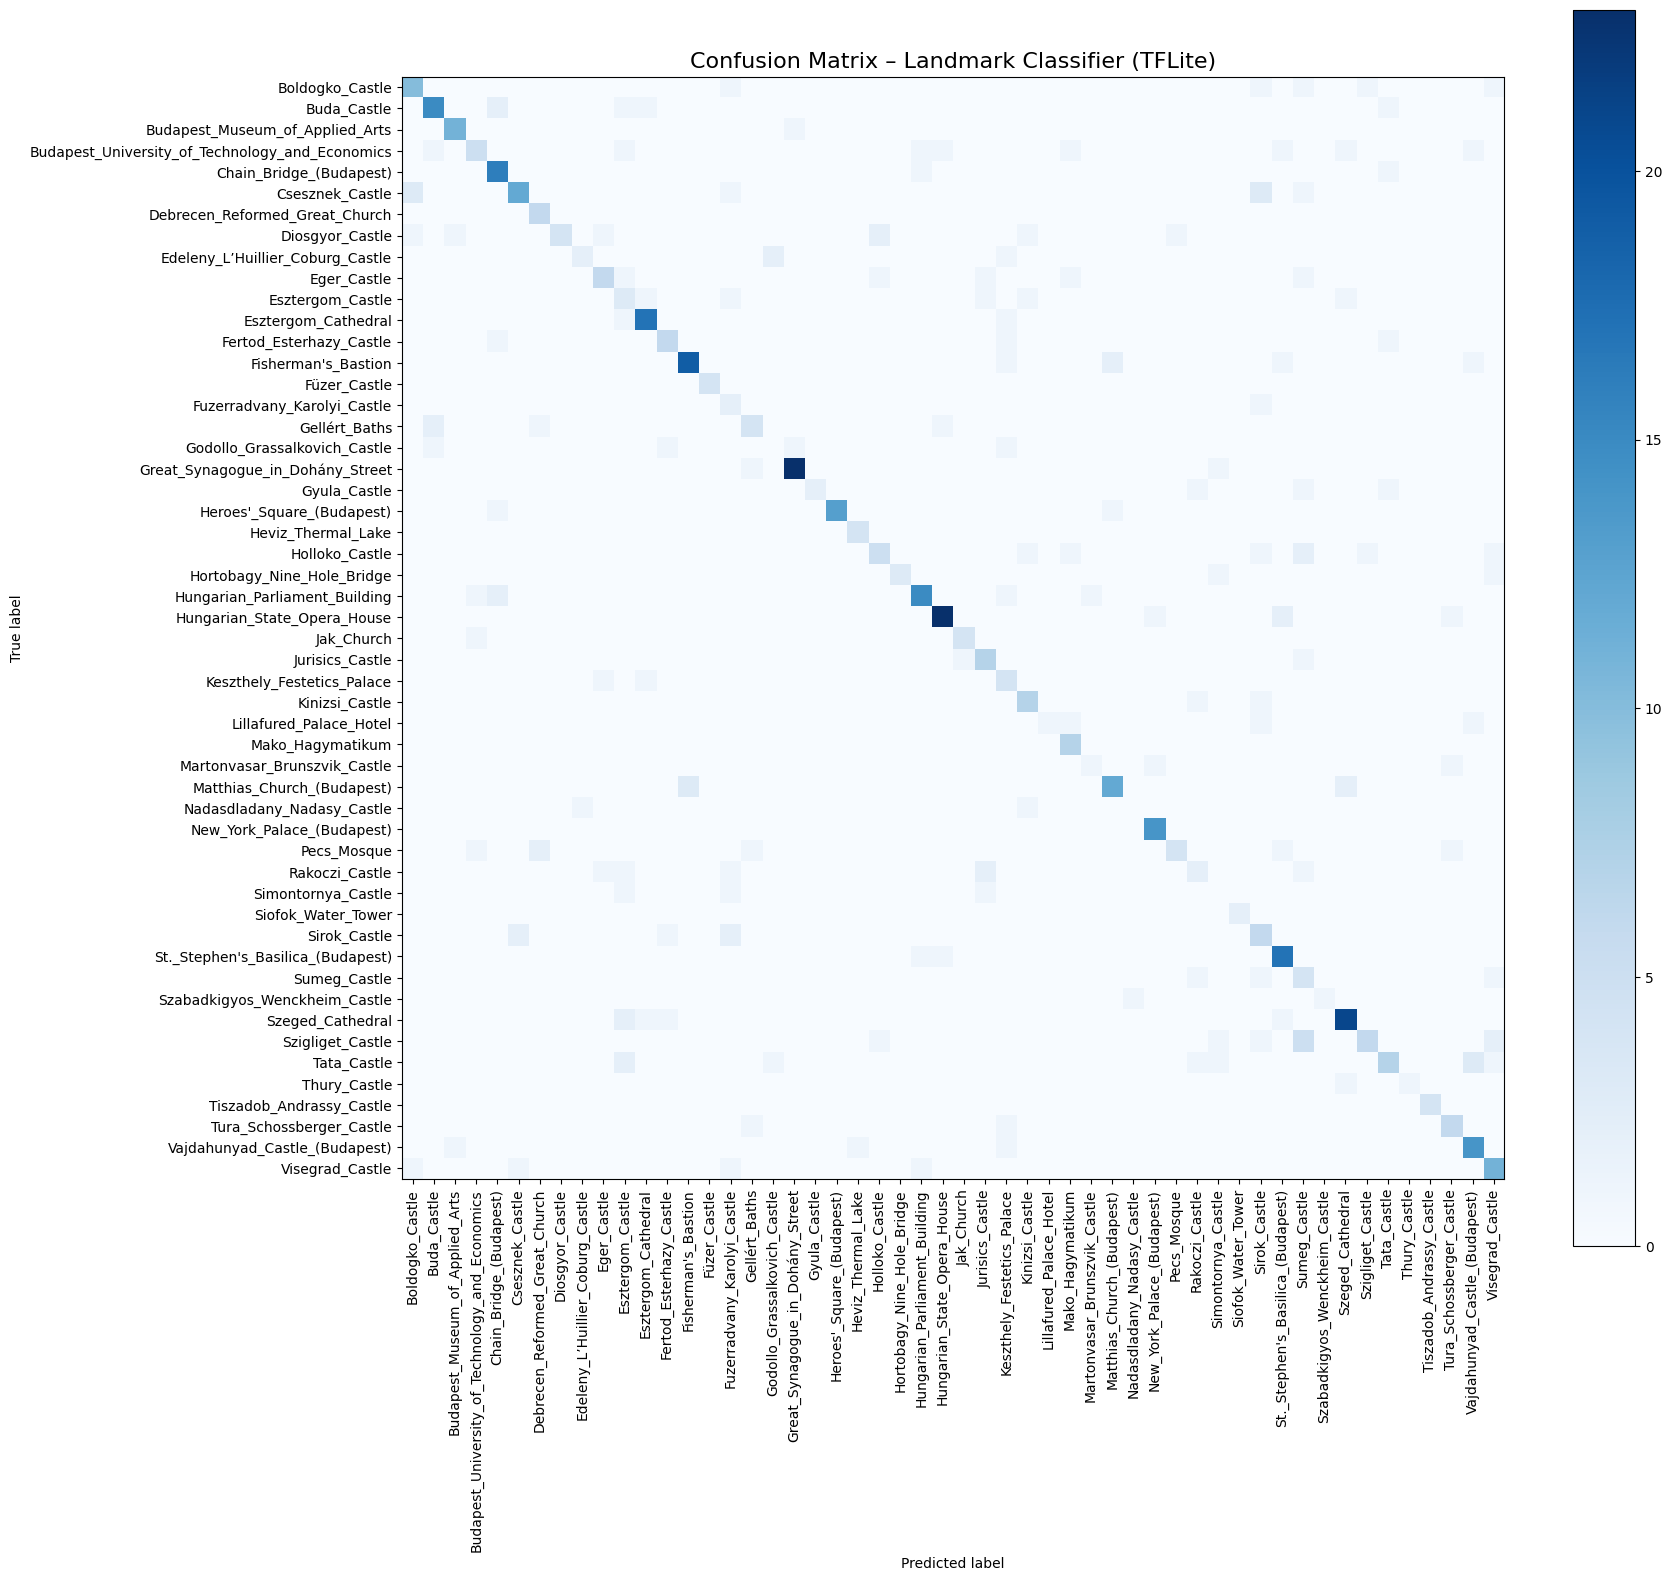

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(18, 16))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix – Landmark Classifier (TFLite)", fontsize=16)
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.tight_layout()
plt.show()


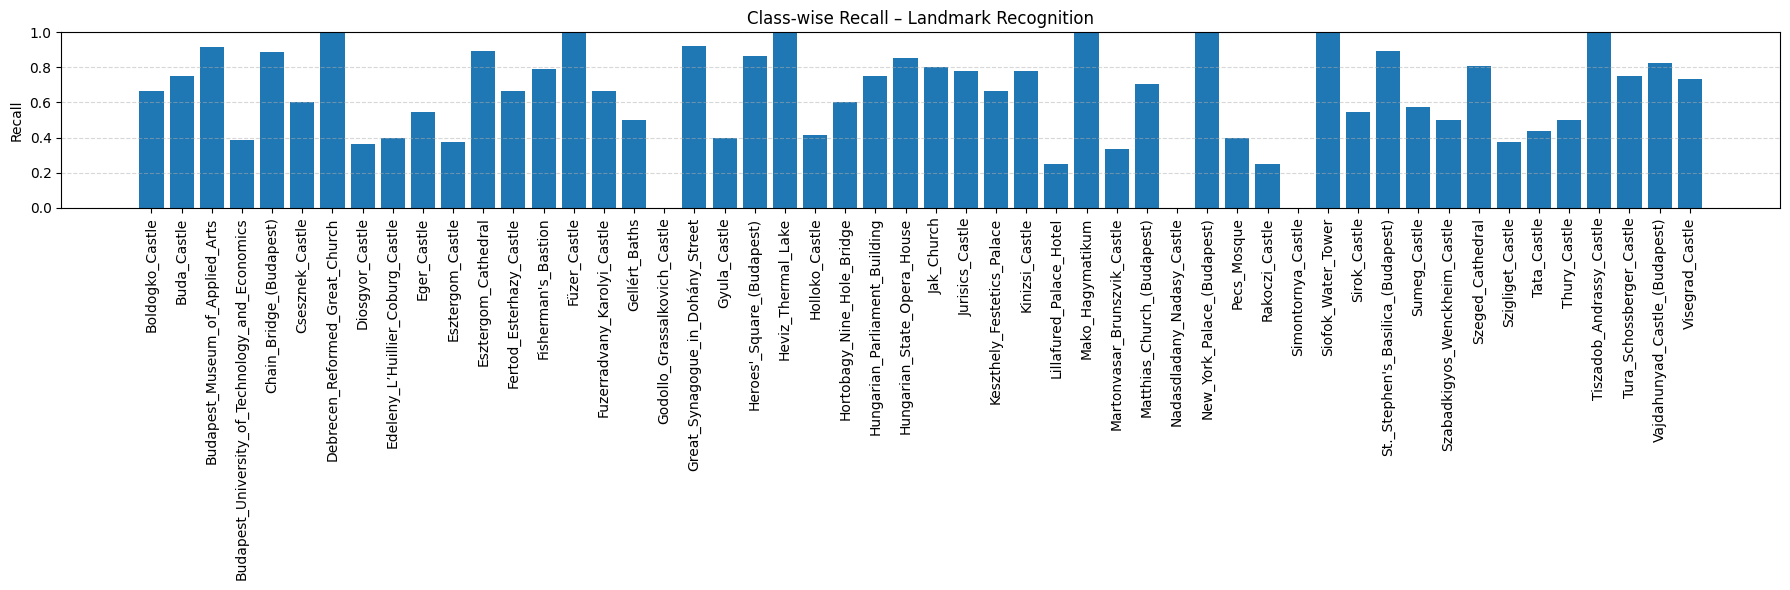

In [12]:
from sklearn.metrics import recall_score

recalls = recall_score(y_true, y_pred, average=None)

plt.figure(figsize=(18, 6))
plt.bar(class_names, recalls)
plt.xticks(rotation=90)
plt.ylabel("Recall")
plt.title("Class-wise Recall – Landmark Recognition")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


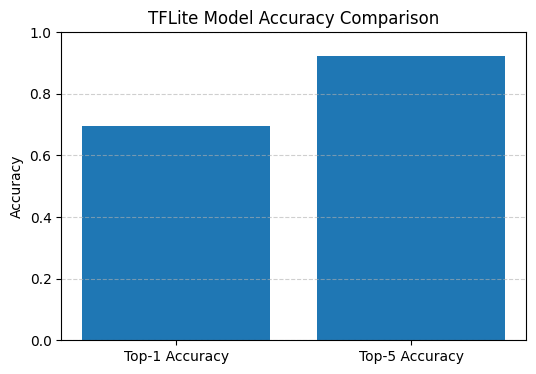

In [13]:
plt.figure(figsize=(6, 4))
plt.bar(
    ["Top-1 Accuracy", "Top-5 Accuracy"],
    [top1_acc, top5_acc]
)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("TFLite Model Accuracy Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


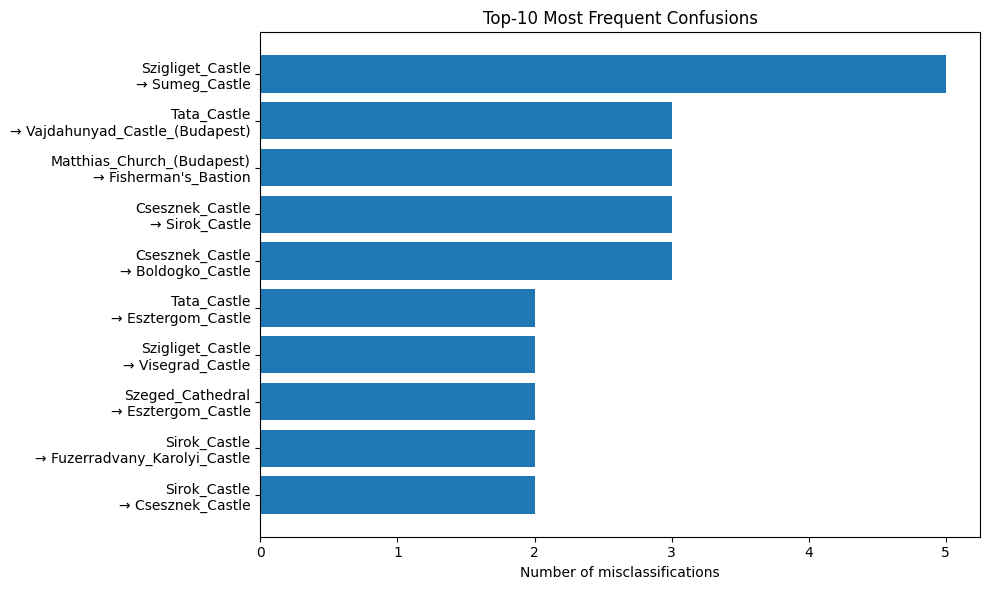

In [14]:
confusions = []

for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            confusions.append((cm[i, j], class_names[i], class_names[j]))

confusions = sorted(confusions, reverse=True)[:10]

labels = [f"{a}\n→ {b}" for _, a, b in confusions]
values = [v for v, _, _ in confusions]

plt.figure(figsize=(10, 6))
plt.barh(labels, values)
plt.xlabel("Number of misclassifications")
plt.title("Top-10 Most Frequent Confusions")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
